In [3]:
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc

import py_compile
py_compile.compile('process.py')
from process import *

# load in data
data_path='../data_extraction/data/'

cohort = pd.read_table(data_path+'cohort.tsv')

cohort.ix[cohort.age > 90, 'age']=90

urine = pd.read_csv(data_path+'urine.csv')
urine = urine.loc[urine['value'] < 5000]

maps = pd.read_csv(data_path+'map.csv')
creatinine = pd.read_csv(data_path+'creatinine.csv')
admission_creatinine = pd.read_csv(data_path+'admission_creatinine.csv')


In [2]:
# Interpolate the weights

cohort.set_index('icustay_id', inplace=True)

cohort = interpolateweights(cohort)

# Compute the urine blocks
aki_urine = calculateurineaki(urine, cohort)
cohort = pd.read_table(data_path+'cohort.tsv')

In [4]:
# Get ethnicities 
eth = geteth(cohort)

In [5]:
# clean the lactate
cohort = cohort.loc[cohort['max_lactate'] < 100]
cohort = cohort[pd.notnull(cohort['max_lactate'])]

In [6]:
# Get map features 
map_cutoffs = np.append(np.arange(30,100,10),200)
mean_maps, min_maps, map_fracs = getmapfeatures(maps,map_cutoffs)

Fraction of hours missing MAP values: 0.0727082162255


In [8]:
# Process creatinine values and calculate aki 
creat_summary = analyzecreatinine(creatinine, admission_creatinine)

In [9]:
# Get the logistic regression data
lr_data, aki_dataset, non_aki_dataset = getlrdata(cohort, eth, min_maps, map_fracs, creat_summary, aki_urine)

In [10]:
# Summarize results

#AKI
print "------------------------------- AKI Patients -------------------------------"
print "============================================================================"
get_summary(aki_dataset)

#Non-AKI
print "----------------------------- Non-AKI Patients -----------------------------"
print "============================================================================"
get_summary(non_aki_dataset)

#Overall
print "------------------------------- All Patients -------------------------------"
print "============================================================================"
get_summary(lr_data)

------------------------------- AKI Patients -------------------------------
               age          los  max_lactate    vaso_frac      min_map
count  2942.000000  2942.000000  2942.000000  2942.000000  2942.000000
mean     65.531381    12.980428     3.340445     0.159124    46.299796
std      16.284654    11.297079     2.823739     0.228874     9.410704
min      18.340391     3.001000     0.500000     0.000000    30.333300
25%      54.343115     5.344375     1.600000     0.000000    39.000000
50%      67.386841     9.314600     2.400000     0.042935    46.000000
75%      78.344660    16.317650     4.000000     0.243792    52.000000
max      90.000000   173.072500    27.700000     0.995077   102.000000

gender:
M    1502
F    1440
dtype: int64

M    0.510537
F    0.489463
dtype: float64

ethnicity:
WHITE                            2218
UNKNOWN                           340
BLACK/AFRICAN AMERICAN            194
HISPANIC/LATINO                    79
MULTI/OTHER                       

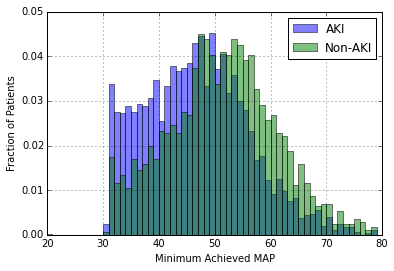

In [11]:
# Look at MAP split between AKI and Non-AKI subsets
bins = np.arange(20,80,1)

aki_dataset['min_map'].hist(alpha=0.5, bins = bins, label='AKI',normed=True)
non_aki_dataset['min_map'].hist(alpha=0.5, bins = bins, label='Non-AKI',normed=True)

plt.legend(loc='upper right')
plt.xlabel('Minimum Achieved MAP')
plt.ylabel('Fraction of Patients')
plt.show()

        (30, 40]    (40, 50]     (50, 60]     (60, 70]     (70, 80]  \
count  96.000000  571.000000  2030.000000  2741.000000  2912.000000   
mean    0.017047    0.035573     0.100947     0.260219     0.294333   
std     0.015002    0.040624     0.108725     0.168428     0.137958   
min     0.014085    0.014085     0.014085     0.014085     0.014085   
25%     0.014085    0.014085     0.028169     0.112676     0.197183   
50%     0.014085    0.014493     0.056338     0.239437     0.295775   
75%     0.014085    0.042254     0.140845     0.385714     0.380282   
max     0.125000    0.338028     0.676056     0.830769     1.000000   

          (80, 90]    (90, 200]  
count  2854.000000  2595.000000  
mean      0.208224     0.212138  
std       0.125498     0.217255  
min       0.014085     0.014085  
25%       0.112676     0.044118  
50%       0.197183     0.126761  
75%       0.295775     0.309859  
max       0.842857     1.000000  


/Users/nalinisingh/dev/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


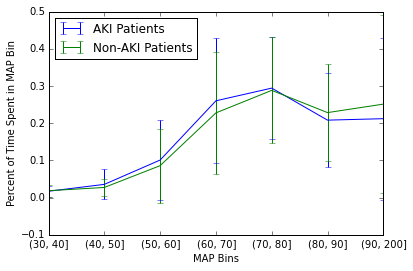

In [12]:
# Plot of percent of time spent within each MAP bin
map_labels = ['(30, 40]','(40, 50]','(50, 60]','(60, 70]','(70, 80]','(80, 90]','(90, 200]']

aki_map_avg = aki_dataset[map_labels].describe()
non_aki_map_avg = non_aki_dataset[map_labels].describe()
all_map_avg = lr_data[map_labels].describe()
print aki_map_avg
ind_avg = 1
ind_std = 2

row = aki_map_avg.iloc[ind_avg]
row.plot(kind='line',yerr=aki_map_avg.iloc[ind_std],label='AKI Patients')

row = non_aki_map_avg.iloc[ind_avg]
row.plot(kind='line',yerr=non_aki_map_avg.iloc[ind_std],label='Non-AKI Patients')

plt.legend(loc='upper left')
plt.xlabel('MAP Bins')
plt.ylabel('Percent of Time Spent in MAP Bin')

In [69]:
# Organize data for logistic regression

cols = lr_data[['age','gender','eth','los','max_lactate','vaso_frac','min_map']]
labels = lr_data[['aki']]

# Explicitly get dummy variables for categoricals

cols['gender'] = pd.Categorical(cols['gender'])
gender_dummies = pd.get_dummies(cols['gender'], prefix='gender')
cols = cols.join(gender_dummies.ix[:, 'gender_2':])
del cols['gender']
del cols['gender_M'] # delete reference group to prevent multicollinearity

cols['eth'] = pd.Categorical(cols['eth'])
gender_dummies = pd.get_dummies(cols['eth'], prefix='eth')
cols = cols.join(gender_dummies.ix[:, 'eth':])
del cols['eth']
del cols['eth_WHITE'] # delete reference group to prevent multicollinearity

# Manually add the intercept
cols['intercept'] = 1.0

# Split 90-10 training test
np.random.seed(0)
msk = np.random.rand(len(lr_data)) < 0.9
train_set = cols[msk]
test_set = cols[~msk]

train_labels = labels[msk]
test_labels = labels[~msk]


# Do logistic regression
logit = sm.Logit(train_labels, train_set)
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.609517
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    aki   No. Observations:                 4178
Model:                          Logit   Df Residuals:                     4165
Method:                           MLE   Df Model:                           12
Date:                Fri, 16 Dec 2016   Pseudo R-squ.:                 0.07487
Time:                        09:26:43   Log-Likelihood:                -2546.6
converged:                       True   LL-Null:                       -2752.7
                                        LLR p-value:                 9.899e-81
                                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
age                                   0.0151      0.002      7

In [70]:
# Get odds ratios and confidence intervals

conf = result.conf_int()
conf['OR'] = result.params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

                                       2.5%      97.5%        OR
age                                1.011062   1.019353  1.015199
los                                1.040300   1.060089  1.050148
max_lactate                        1.024666   1.085123  1.054461
vaso_frac                          0.906933   1.791647  1.274717
min_map                            0.963949   0.978729  0.971311
gender_F                           0.876828   1.147179  1.002935
eth_AMERICAN INDIAN/ALASKA NATIVE  0.034230  10.104350  0.588112
eth_ASIAN                          0.269452   0.641088  0.415623
eth_BLACK/AFRICAN AMERICAN         0.766859   1.317936  1.005321
eth_HISPANIC/LATINO                0.545082   1.117627  0.780511
eth_MULTI/OTHER                    0.538609   1.235866  0.815873
eth_UNKNOWN                        0.738482   1.120014  0.909456
intercept                          0.793584   2.398081  1.379521


In [71]:
# Compute AUC

test_set['pred'] = result.predict(test_set)
fpr, tpr, thresholds = roc_curve(test_labels, test_set['pred'])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.708094
